**Resources:**
- [Article](https://www.linkedin.com/pulse/bert-multi-class-text-classification-your-dataset-kumar-deepak?articleId=6599156459685154816)
- [GitHub](https://github.com/kumardeepak/bert-multi-class) (that contains the notebook)

# Loading the libraries

In [1]:
!pip install transformers

     |████████████████████████████████| 757kB 10.1MB/s 
     |████████████████████████████████| 3.0MB 50.0MB/s 
     |████████████████████████████████| 1.1MB 43.9MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=1c4a1279eb593b72b2f6ef361ab4dd0a5fc584f9bb9bc5dbb84ed0ae3b5b7775
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# loading drive to access the data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Note:** I changed the `WarmupLinearSchedule` to `get_linear_schedule_with_warmup` using this [helpful issue](https://github.com/huggingface/transformers/issues/2082) as a reference.

In [3]:
import pandas as pd
import uuid
import os
import random
from argparse import Namespace

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.utils.data.distributed import DistributedSampler

from tqdm import tqdm, trange

from transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer)
from transformers import AdamW, get_linear_schedule_with_warmup

MODEL_CLASSES = { 'bert': (BertConfig, BertForSequenceClassification, BertTokenizer) }

#import warnings
#warnings.filterwarnings("ignore")

import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

# Data Playground

## Slice the data into two

In [4]:
import numpy as np
data = pd.read_csv('/content/drive/My Drive/Team 4/WorkOnMergedData/final_merged_data.csv')
data['Leading Comment'] = data['Leading Comment'].apply(lambda x: str(x))
data['Category'] = data['Category'].apply(lambda x: str(x))
df = data[['Leading Comment', 'Category']] 
df.head()

,Leading Comment,Category
0,Yesterday I lowered the price of an item to ma...,Fulfillment By Amazon
1,I got my new credit card and before I could up...,Fulfillment By Amazon
2,I sent an FBA shipment on November 26. They sh...,Fulfillment By Amazon
3,"Hi, I need to know the products stock in Selle...",Fulfillment By Amazon
4,Just here to vent at the Asia based Seller Sup...,Fulfillment By Amazon


In [5]:
df.rename(columns={'Leading Comment': 'texts', 'Category': 'labels'}, inplace=True)
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,texts,labels
0,Yesterday I lowered the price of an item to ma...,Fulfillment By Amazon
1,I got my new credit card and before I could up...,Fulfillment By Amazon
2,I sent an FBA shipment on November 26. They sh...,Fulfillment By Amazon
3,"Hi, I need to know the products stock in Selle...",Fulfillment By Amazon
4,Just here to vent at the Asia based Seller Sup...,Fulfillment By Amazon


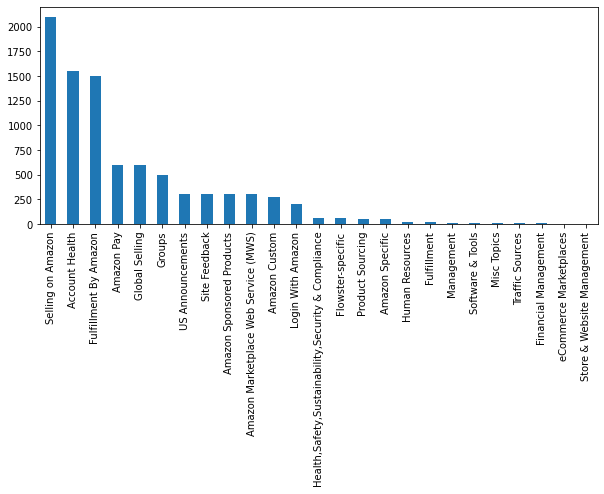

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
df.labels.value_counts().plot(kind='bar');

In [206]:
df.labels.unique()

array(['Fulfillment By Amazon', 'Amazon Sponsored Products',
       'Account Health', 'Selling on Amazon', 'Global Selling', 'Groups',
       'Health,Safety,Sustainability,Security & Compliance',
       'Amazon Marketplace Web Service (MWS)', 'Login With Amazon',
       'Amazon Pay', 'Amazon Custom', 'US Announcements', 'Site Feedback',
       'Financial Management', 'Product Sourcing', 'Human Resources',
       'Amazon Specific', 'Flowster-specific', 'Software & Tools',
       'Fulfillment', 'Traffic Sources', 'Management', 'Misc Topics',
       'eCommerce Marketplaces', 'Store & Website Management'],
      dtype=object)

In [207]:
df.labels.unique().shape

(25,)

In [7]:
categories = ['Fulfillment By Amazon', 'Amazon Sponsored Products',
       'Account Health', 'Selling on Amazon', 'Global Selling', 'Groups',
       'Health,Safety,Sustainability,Security & Compliance',
       'Amazon Marketplace Web Service (MWS)', 'Login With Amazon',
       'Amazon Pay', 'Amazon Custom', 'US Announcements', 'Site Feedback',
       'Financial Management', 'Product Sourcing', 'Human Resources',
       'Amazon Specific', 'Flowster-specific', 'Software & Tools',
       'Fulfillment', 'Traffic Sources', 'Management', 'Misc Topics',
       'eCommerce Marketplaces', 'Store & Website Management']

In [8]:
# categories with less data
categ_wld = ['Health,Safety,Sustainability,Security & Compliance',
       'Financial Management', 'Product Sourcing', 'Human Resources',
       'Amazon Specific', 'Flowster-specific', 'Software & Tools',
       'Fulfillment', 'Traffic Sources', 'Management', 'Misc Topics',
       'eCommerce Marketplaces', 'Store & Website Management']
len(categ_wld)

13

In [9]:
# dataframe with only the categories containing less data
data_wlc = df[df['labels'].isin(categ_wld)]

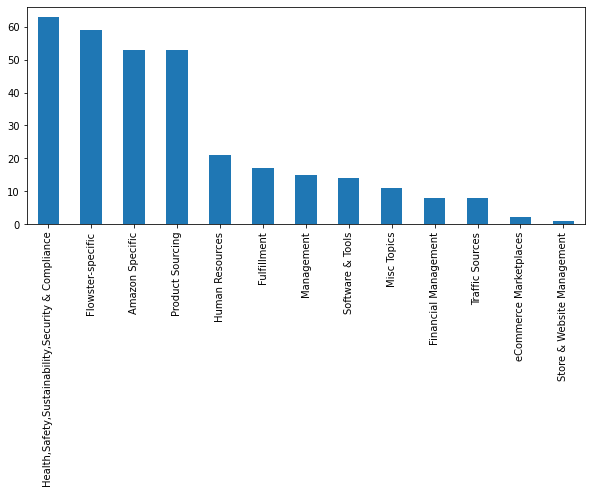

In [16]:
plt.figure(figsize=(10,4))
data_wlc.labels.value_counts().plot(kind='bar');

In [17]:
categ_wed = []
for categ in categories:
  if categ not in categ_wld:
    # category with enough data
    categ_wed.append(categ)

In [18]:
len(categ_wed)

12

In [19]:
# dataframe with only the categories containing enough data
data_wec = df[df['labels'].isin(categ_wed)]

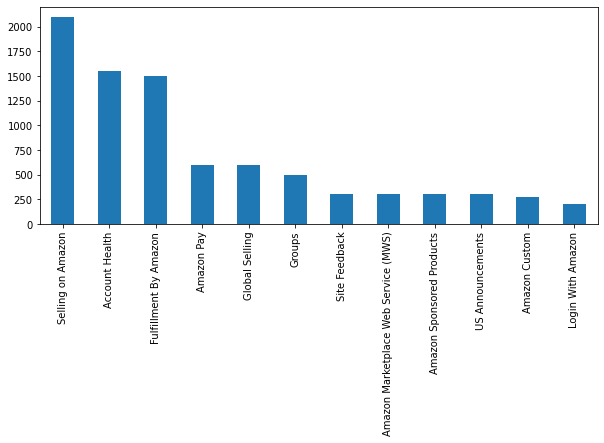

In [20]:
plt.figure(figsize=(10,4))
data_wec.labels.value_counts().plot(kind='bar');

In [21]:
data_wec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8516 entries, 0 to 8578
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   8516 non-null   object
 1   labels  8516 non-null   object
dtypes: object(2)
memory usage: 199.6+ KB


## Augment the data

In [22]:
!pip install git+https://github.com/makcedward/nlpaug.git numpy matplotlib python-dotenv

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-ncbs6o_0
  Running command git clone -q https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-ncbs6o_0
  Created wheel for nlpaug: filename=nlpaug-0.0.14-cp36-none-any.whl size=583433 sha256=5c0ce08d8591ec91302697983378ed0026adc8ab804664935a70b074ffb0579b
  Stored in directory: /tmp/pip-ephem-wheel-cache-y6bw42ob/wheels/2b/ef/30/a4e22f9a97373c9ab6763670c94aa5e111b0b956983f3892a4
Successfully built nlpaug


In [23]:
cd /content/drive/My Drive/Team 4/WorkOnMergedData

/content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData


In [24]:
!git clone https://github.com/makcedward/nlpaug.git

fatal: destination path 'nlpaug' already exists and is not an empty directory.


In [25]:
cd nlpaug

/content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData/nlpaug


In [26]:
import os
os.environ["MODEL_DIR"] = '../model'

In [27]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [28]:
# augmenting with BERT
texts = data_wlc['texts']
augmented_text_bert = []
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")
for text in texts:
  augmented_text_bert.append(aug.augment(text))

07/02/2020 18:40:02 - INFO - filelock -   Lock 139686114574120 acquired on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
07/02/2020 18:40:02 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpo5p4ze19


07/02/2020 18:40:04 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt in cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
07/02/2020 18:40:04 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
07/02/2020 18:40:04 - INFO - filelock -   Lock 139686114574120 released on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
07/02/2020 18:40:04 - INFO - transformers.tokenization_utils_base -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/tor

07/02/2020 18:40:04 - INFO - filelock -   Lock 139686114646616 acquired on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock
07/02/2020 18:40:04 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp01m5ikza


07/02/2020 18:40:05 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json in cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
07/02/2020 18:40:05 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
07/02/2020 18:40:05 - INFO - filelock -   Lock 139686114646616 released on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock
07/02/2020 18:40:05 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /r

07/02/2020 18:40:06 - INFO - filelock -   Lock 139686114648016 acquired on /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock
07/02/2020 18:40:06 - INFO - transformers.file_utils -   https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpqlrbjzk_


07/02/2020 18:40:11 - INFO - transformers.file_utils -   storing https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin in cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
07/02/2020 18:40:11 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
07/02/2020 18:40:11 - INFO - filelock -   Lock 139686114648016 released on /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock
07/02/2020 18:40:11 - INFO - transformers.modeling_utils -   loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0

07/02/2020 18:40:15 - WARNING - transformers.modeling_utils -   Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
07/02/2020 18:40:15 - WARNING - transformers.modeling_utils -   Some weights of BertForMaskedLM were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it

In [29]:
# augmenting with DistillBERT
texts = data_wlc['texts']
augmented_text_distilbert = []
aug = naw.ContextualWordEmbsAug(
    model_path='distilbert-base-uncased', action="substitute")
for text in texts:
  augmented_text_distilbert.append(aug.augment(text))

07/02/2020 18:42:06 - INFO - transformers.tokenization_utils_base -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
07/02/2020 18:42:07 - INFO - filelock -   Lock 139686275405024 acquired on /root/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c.lock
07/02/2020 18:42:07 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpmzs2nfjf


07/02/2020 18:42:08 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json in cache at /root/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c
07/02/2020 18:42:08 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c
07/02/2020 18:42:08 - INFO - filelock -   Lock 139686275405024 released on /root/.cache/torch/transformers/a41e817d5c0743e29e86ff85edc8c257e61bc8d88e4271bb1b243b6e7614c633.8949e27aafafa845a18d98a0e3a88bc2d248bbc32a1b75947366664658f23b1c.lock
07/02/2020 18:42:08 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-config.json from

07/02/2020 18:42:08 - INFO - filelock -   Lock 139686275407376 acquired on /root/.cache/torch/transformers/ae9df7a8d658c4f3e1917a471a8a21cf678fa1d4cb91e7702dfe0598dbdcf354.c2015533705b9dff680ae707e205a35e2860e8d148b45d35085419d74fe57ac5.lock
07/02/2020 18:42:08 - INFO - transformers.file_utils -   https://cdn.huggingface.co/distilbert-base-uncased-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp841876us


07/02/2020 18:42:11 - INFO - transformers.file_utils -   storing https://cdn.huggingface.co/distilbert-base-uncased-pytorch_model.bin in cache at /root/.cache/torch/transformers/ae9df7a8d658c4f3e1917a471a8a21cf678fa1d4cb91e7702dfe0598dbdcf354.c2015533705b9dff680ae707e205a35e2860e8d148b45d35085419d74fe57ac5
07/02/2020 18:42:11 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/ae9df7a8d658c4f3e1917a471a8a21cf678fa1d4cb91e7702dfe0598dbdcf354.c2015533705b9dff680ae707e205a35e2860e8d148b45d35085419d74fe57ac5
07/02/2020 18:42:11 - INFO - filelock -   Lock 139686275407376 released on /root/.cache/torch/transformers/ae9df7a8d658c4f3e1917a471a8a21cf678fa1d4cb91e7702dfe0598dbdcf354.c2015533705b9dff680ae707e205a35e2860e8d148b45d35085419d74fe57ac5.lock
07/02/2020 18:42:11 - INFO - transformers.modeling_utils -   loading weights file https://cdn.huggingface.co/distilbert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/ae9df7a

07/02/2020 18:42:13 - INFO - transformers.modeling_utils -   All model checkpoint weights were used when initializing DistilBertForMaskedLM.

07/02/2020 18:42:13 - INFO - transformers.modeling_utils -   All the weights of DistilBertForMaskedLM were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use DistilBertForMaskedLM for predictions without further training.


In [30]:
# bert-base-uncased
print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_bert[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
amazon is asking me to provide them with a registration of my product . they did submit them a registration but they said it ’ s not the correct one . they buy the ingredient of the capsules from a manua restaurant , then i rep milk it and eat . i have know clue on how to register on the amazon website since they only allowed me to register a food facility . god help me ! ! !


In [31]:
# distillbert-base-uncased
print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_distilbert[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
amazon is asking me who provide them with a registration of my product . i did submit them a registration but they found it ’ t not the correct one . i buy the ingredient of the capsules from a manuafacturer , then i repackaged them and sell . they have know information on how to register from their fda register because amazon only allowed me to visit a food facility . please help me ! ! !


In [32]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [33]:
# Substitute word by WordNet's synonym
augmented_text_wordnet = []
aug = naw.SynonymAug(aug_src='wordnet')
for text in texts:
  augmented_text_wordnet.append(aug.augment(text))

print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_wordnet[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
Amazon cost call for me to provide them with a enrollment of my product . I did accede them a registration but they said information technology ’ s not the right one . I buy the ingredient of the capsules from a manuafacturer , then I repackaged them and sell . Ace have know clue on how to register on the FDA website because they only allowed me to register a food facility . Please help maine ! ! !


In [34]:
# Substitute word by GPT2's synonym
aug = nas.ContextualWordEmbsForSentenceAug(model_path='gpt2')
augmented_text_gpt2 = []
for text in texts:
  augmented_text_gpt2.append(aug.augment(text))

print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text_gpt2)

07/02/2020 18:44:25 - INFO - filelock -   Lock 139684238118528 acquired on /root/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71.lock
07/02/2020 18:44:25 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpf1j62b6y


07/02/2020 18:44:28 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json in cache at /root/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
07/02/2020 18:44:28 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
07/02/2020 18:44:28 - INFO - filelock -   Lock 139684238118528 released on /root/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71.lock


07/02/2020 18:44:29 - INFO - filelock -   Lock 139684202718936 acquired on /root/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
07/02/2020 18:44:29 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp47xafghc


07/02/2020 18:44:30 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt in cache at /root/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
07/02/2020 18:44:30 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
07/02/2020 18:44:30 - INFO - filelock -   Lock 139684202718936 released on /root/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
07/02/2020 18:44:30 - INFO - transformers.tokenization_utils_base -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json from cache at /root/.cache/torch/transformers/f2808208

07/02/2020 18:44:31 - INFO - filelock -   Lock 139684191830872 acquired on /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e.lock
07/02/2020 18:44:31 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmph0nhc565


07/02/2020 18:44:32 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json in cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e
07/02/2020 18:44:32 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e
07/02/2020 18:44:32 - INFO - filelock -   Lock 139684191830872 released on /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.db13c9bc9c7bdd738ec89e069621d88e05dc670366092d809a9cbcac6798e24e.lock
07/02/2020 18:44:32 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transform

07/02/2020 18:45:19 - INFO - transformers.file_utils -   storing https://cdn.huggingface.co/gpt2-pytorch_model.bin in cache at /root/.cache/torch/transformers/d71fd633e58263bd5e91dd3bde9f658bafd81e11ece622be6a3c2e4d42d8fd89.778cf36f5c4e5d94c8cd9cefcf2a580c8643570eb327f0d4a1f007fab2acbdf1
07/02/2020 18:45:19 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/d71fd633e58263bd5e91dd3bde9f658bafd81e11ece622be6a3c2e4d42d8fd89.778cf36f5c4e5d94c8cd9cefcf2a580c8643570eb327f0d4a1f007fab2acbdf1
07/02/2020 18:45:19 - INFO - filelock -   Lock 139684179605600 released on /root/.cache/torch/transformers/d71fd633e58263bd5e91dd3bde9f658bafd81e11ece622be6a3c2e4d42d8fd89.778cf36f5c4e5d94c8cd9cefcf2a580c8643570eb327f0d4a1f007fab2acbdf1.lock
07/02/2020 18:45:19 - INFO - transformers.modeling_utils -   loading weights file https://cdn.huggingface.co/gpt2-pytorch_model.bin from cache at /root/.cache/torch/transformers/d71fd633e58263bd5e91dd3bde9f658bafd81e11ece62

07/02/2020 18:45:23 - INFO - transformers.modeling_utils -   All model checkpoint weights were used when initializing GPT2LMHeadModel.

07/02/2020 18:45:23 - WARNING - transformers.modeling_utils -   Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original:
Have questions about Store & Website Management? This is the category to use. Please be sure to select the most appropriate sub-category for your questions.
Augmented Text:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!! Thanks for checking my product.', 'Account infringement is complained, I submitted multiple action plans to the Amazon team, but it didn’t work. Later, Amazon offers a complainant’s information I tried to contact the other party, but they did not reply to me. I hired a lawyer to contact them, and they did not respond, My shop was closed for more than 40 days and I received a subpoena from the court. I want to consult everyone, If the other part

In [35]:
# Substitute word by Roberta's synonym
aug = naw.ContextualWordEmbsAug(
    model_path='roberta-base', action="substitute")
augmented_text_roberta = []
for text in texts:
  augmented_text_roberta.append(aug.augment(text))

print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text_roberta)

07/02/2020 18:46:34 - INFO - filelock -   Lock 139684176607888 acquired on /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock
07/02/2020 18:46:34 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpzi3riz8o


07/02/2020 18:46:36 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json in cache at /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
07/02/2020 18:46:36 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
07/02/2020 18:46:36 - INFO - filelock -   Lock 139684176607888 released on /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock


07/02/2020 18:46:37 - INFO - filelock -   Lock 139686114780272 acquired on /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
07/02/2020 18:46:37 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpveandrwq


07/02/2020 18:46:39 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt in cache at /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
07/02/2020 18:46:39 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
07/02/2020 18:46:39 - INFO - filelock -   Lock 139686114780272 released on /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
07/02/2020 18:46:39 - INFO - transformers.tokenization_utils_base -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /root/.cache/torch/trans

07/02/2020 18:46:40 - INFO - filelock -   Lock 139684176606992 acquired on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690.lock
07/02/2020 18:46:40 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpe8jkm5nz


07/02/2020 18:46:41 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json in cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
07/02/2020 18:46:41 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
07/02/2020 18:46:41 - INFO - filelock -   Lock 139684176606992 released on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690.lock
07/02/2020 18:46:41 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache

07/02/2020 18:46:41 - INFO - filelock -   Lock 139686355398784 acquired on /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e.lock
07/02/2020 18:46:41 - INFO - transformers.file_utils -   https://cdn.huggingface.co/roberta-base-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpw1lf9hj4


07/02/2020 18:46:47 - INFO - transformers.file_utils -   storing https://cdn.huggingface.co/roberta-base-pytorch_model.bin in cache at /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e
07/02/2020 18:46:47 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e
07/02/2020 18:46:47 - INFO - filelock -   Lock 139686355398784 released on /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e.lock
07/02/2020 18:46:47 - INFO - transformers.modeling_utils -   loading weights file https://cdn.huggingface.co/roberta-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f0

07/02/2020 18:46:53 - INFO - transformers.modeling_utils -   All model checkpoint weights were used when initializing RobertaForMaskedLM.

07/02/2020 18:46:53 - WARNING - transformers.modeling_utils -   Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Original:
Have questions about Store & Website Management? This is the category to use. Please be sure to select the most appropriate sub-category for your questions.
Augmented Text:
[' FDA is asking me to send them with a registration of my products I did submit them a schedule but they said it � � d not the correct one . I buy the ingredient of the products from a man u af act urer , then I rep ack aged them and sell . I have know idea on how they get on the FDA website because they only allowed me to register a small facility . Please help me !!!', ' Account infringement was complained , I submitted this action plans to my Amazon team , but it didn � t work . Later , Amazon offers a complainant � � s information I tried to contact the other party , but they did not reply to me . I hired a lawyer to contact them , and they did not respond , My shop is closed for less than 40 days and I received a subpoena from the court . I want to consult everyone , If the other party had already wi

In [36]:
import sklearn.datasets
import re

import nlpaug.augmenter.word as naw
import nlpaug.model.word_stats as nmw

def _tokenizer(text, token_pattern=r"(?u)\b\w\w+\b"):
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(text)

# Load sample data
train_data = sklearn.datasets.fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
train_x = train_data.data

# Tokenize input
train_x_tokens = [_tokenizer(x) for x in train_x]

# Train TF-IDF model
tfidf_model = nmw.TfIdf()
tfidf_model.train(train_x_tokens)
tfidf_model.save('.')

# Load TF-IDF augmenter
aug = naw.TfIdfAug(model_path='.', tokenizer=_tokenizer)

texts = data_wlc['texts']

augmented_text_tfidf = []
for text in texts:
  augmented_text_tfidf.append(aug.augment(text))

07/02/2020 18:47:57 - INFO - sklearn.datasets._twenty_newsgroups -   Downloading 20news dataset. This may take a few minutes.
07/02/2020 18:47:57 - INFO - sklearn.datasets._twenty_newsgroups -   Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


In [37]:
print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_tfidf[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
Amazon GEEX asking me to provide them with registration of excitatory product Cheers submit them registration but they said it not the correct one buy the ingredient of the capsules O0IVBUDK manuafacturer then repackaged them and sell 5J52L know IOC on how Procurator register on the FDA website because they rust allowed me to register food Did Please help winger


In [38]:
# augmenting with bert
aug_data = pd.DataFrame({'texts':augmented_text_bert,
                         'labels': data_wlc['labels']})
aug_data.head()

,texts,labels
4202,amazon is asking me to provide them with a reg...,"Health,Safety,Sustainability,Security & Compli..."
4203,"account confusion is complained , i submitted ...","Health,Safety,Sustainability,Security & Compli..."
4204,hi … amazon classified about 17 of my listings...,"Health,Safety,Sustainability,Security & Compli..."
4205,"hello there , amazon suspended my account and ...","Health,Safety,Sustainability,Security & Compli..."
4206,"you , just asked me why i installed suspected ...","Health,Safety,Sustainability,Security & Compli..."


In [39]:
# augmenting with distillbert
aug_data = aug_data.append(pd.DataFrame({'texts':augmented_text_distilbert,
                         'labels': data_wlc['labels']}))
aug_data.head()

,texts,labels
4202,amazon is asking me to provide them with a reg...,"Health,Safety,Sustainability,Security & Compli..."
4203,"account confusion is complained , i submitted ...","Health,Safety,Sustainability,Security & Compli..."
4204,hi … amazon classified about 17 of my listings...,"Health,Safety,Sustainability,Security & Compli..."
4205,"hello there , amazon suspended my account and ...","Health,Safety,Sustainability,Security & Compli..."
4206,"you , just asked me why i installed suspected ...","Health,Safety,Sustainability,Security & Compli..."


In [40]:
# augmenting with gpt2
aug_data = aug_data.append(pd.DataFrame({'texts':augmented_text_gpt2,
                              'labels': data_wlc['labels']}))

In [41]:
# augmenting with roberta
aug_data = aug_data.append(pd.DataFrame({'texts':augmented_text_roberta,
                              'labels': data_wlc['labels']}))

In [42]:
# augmenting with tf-idf
aug_data = aug_data.append(pd.DataFrame({'texts':augmented_text_tfidf,
                              'labels': data_wlc['labels']}))

In [43]:
# augmenting with wordnet
aug_data = aug_data.append(pd.DataFrame({'texts':augmented_text_wordnet,
                              'labels': data_wlc['labels']}))

In [44]:
aug_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1950 entries, 4202 to 8840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   1950 non-null   object
 1   labels  1950 non-null   object
dtypes: object(2)
memory usage: 45.7+ KB


In [45]:
aug_data_wlc = data_wlc.copy()

In [46]:
aug_data_wlc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 4202 to 8840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   325 non-null    object
 1   labels  325 non-null    object
dtypes: object(2)
memory usage: 7.6+ KB


In [47]:
aug_data_wlc = aug_data_wlc.append(aug_data)

In [48]:
aug_data_wlc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2275 entries, 4202 to 8840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   2275 non-null   object
 1   labels  2275 non-null   object
dtypes: object(2)
memory usage: 53.3+ KB


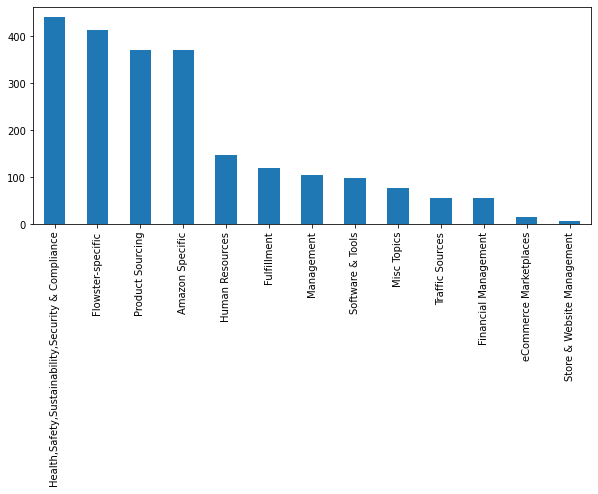

In [49]:
plt.figure(figsize=(10,4))
aug_data_wlc.labels.value_counts().plot(kind='bar');

In [50]:
full_aug_data = data_wec.append(aug_data_wlc)

In [51]:
full_aug_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10791 entries, 0 to 8840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   10791 non-null  object
 1   labels  10791 non-null  object
dtypes: object(2)
memory usage: 252.9+ KB


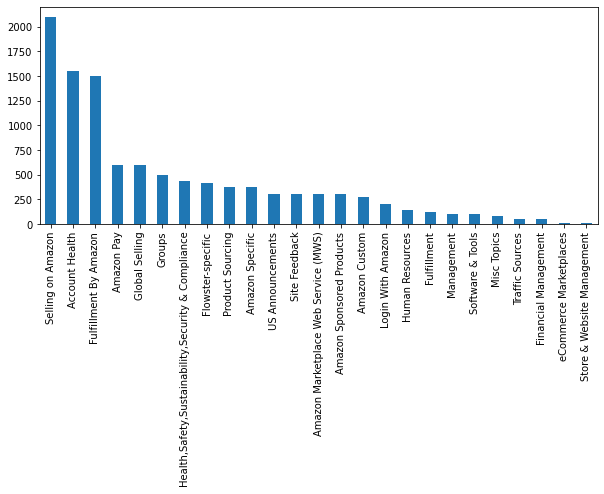

In [52]:
plt.figure(figsize=(10,4))
full_aug_data.labels.value_counts().plot(kind='bar');

In [53]:
cd /content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData

/content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData


In [55]:
full_aug_data['texts'] = full_aug_data['texts'].apply(lambda x: str(x))
full_aug_data['labels'] = full_aug_data['labels'] .apply(lambda x: str(x))

In [56]:
full_aug_data.to_csv('full_aug_data.csv')

# Playing around with the data (slicing - augmenting)
**STEP 1: Slicing the data**  
We will work with the dataframe which categories has data with a minimum of 250 examples.  
**Goal:** Determine if the number of examples in a category affects the performance of the model by `dropping the categories` that had less data.  
The performance improved only by a 0.01.
Perhaps that isn't the problem.  

**STEP 2: Augmenting the data**  
The data has been augmented 5 times by different strategies.  
**Goal:** Determine if the number of examples in a category affects the performance of the model by`augmenting the data of categories` that had less data.

In [250]:
# The above tests where performed on : split the data into 60%, 20%, 20%
#train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [251]:
# split the data into 80%, 10%, 10%
#train, validate, test = np.split(data_wec.sample(frac=1), [int(.8*len(data_wec)), int(.9*len(data_wec))])

In [73]:
data = pd.read_csv('full_aug_data.csv')
data.head()

,Unnamed: 0,texts,labels
0,0,Yesterday I lowered the price of an item to ma...,Fulfillment By Amazon
1,1,I got my new credit card and before I could up...,Fulfillment By Amazon
2,2,I sent an FBA shipment on November 26. They sh...,Fulfillment By Amazon
3,3,"Hi, I need to know the products stock in Selle...",Fulfillment By Amazon
4,4,Just here to vent at the Asia based Seller Sup...,Fulfillment By Amazon


In [74]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [75]:
data.isna().sum()

texts     1
labels    0
dtype: int64

In [76]:
data['texts'][data['texts'].isna()]

8832    NaN
Name: texts, dtype: object

In [77]:
data[data.index==8832]

,texts,labels
8832,NaN,Misc Topics


In [78]:
data.dropna(axis=0, inplace=True)

In [79]:
data.head()

,texts,labels
0,Yesterday I lowered the price of an item to ma...,Fulfillment By Amazon
1,I got my new credit card and before I could up...,Fulfillment By Amazon
2,I sent an FBA shipment on November 26. They sh...,Fulfillment By Amazon
3,"Hi, I need to know the products stock in Selle...",Fulfillment By Amazon
4,Just here to vent at the Asia based Seller Sup...,Fulfillment By Amazon


In [81]:
data.isna().sum()

texts     0
labels    0
dtype: int64

In [82]:
data['texts'] = data['texts'].apply(lambda x: str(x))
data['labels'] = data['labels'] .apply(lambda x: str(x))

In [83]:
# split the data into 80%, 10%, 10%
train, validate, test = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8632 entries, 1512 to 2578
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   8632 non-null   object
 1   labels  8632 non-null   object
dtypes: object(2)
memory usage: 202.3+ KB


In [86]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079 entries, 2279 to 2330
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   1079 non-null   object
 1   labels  1079 non-null   object
dtypes: object(2)
memory usage: 25.3+ KB


In [87]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079 entries, 4636 to 8753
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   1079 non-null   object
 1   labels  1079 non-null   object
dtypes: object(2)
memory usage: 25.3+ KB


In [88]:
train.to_csv("/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented/train.csv")
validate.to_csv("/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented/val.csv")
test.to_csv("/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented/test.csv")

In [89]:
args = Namespace(
    n_gpu=1,
    seed=1337,
    train_batch_size=8,
    per_gpu_train_batch_size=8,
    per_gpu_eval_batch_size=8,
    local_rank=-1,
    max_seq_length= 512,#256, #128
    gradient_accumulation_steps=1,
    learning_rate=5e-5, #
    weight_decay=0.0,
    adam_epsilon=1e-8,
    max_grad_norm=1.0,
    num_train_epochs= 4.0, #4(512)=>70% #3(512)=>68.6% #3(256)=>68% #4.0(128)=> 67%, #3.0(128) => 66%
    max_steps=-1,
    warmup_steps=0,
    model_type='bert',
    data_dir='/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented',
    output_dir='/content/drive/My Drive/Team 4/WorkOnMergedData/model_data_aug',
    train_filepath='',
    valid_filepath='',
    test_filepath='',
    config_name='bert-base-uncased',
    tokenizer_name='bert-base-uncased',
    do_lower_case=True,
    cuda=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

args.train_filepath = os.path.join(args.data_dir, 'train.csv')
args.valid_filepath=os.path.join(args.data_dir, 'val.csv')
args.test_filepath=os.path.join(args.data_dir, 'test.csv')

Using CUDA: True


# Training the model and evaluating it

In [90]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid   = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label  = label

class InputFeatures(object):
    """
    A single set of features of data.

    Args:
        input_ids: Indices of input sequence tokens in the vocabulary.
        attention_mask: Mask to avoid performing attention on padding token indices.
            Mask values selected in ``[0, 1]``:
            Usually  ``1`` for tokens that are NOT MASKED, ``0`` for MASKED (padded) tokens.
        token_type_ids: Segment token indices to indicate first and second portions of the inputs.
        label: Label corresponding to the input
    """

    def __init__(self, input_ids, attention_mask, token_type_ids, label):
        self.input_ids      = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label          = label


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()
        
    def get_test_examples(self):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError() 

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()


In [91]:
class MultiClassProcessor(DataProcessor):
    """Processor for the MultiNLI data set (GLUE version)."""

    def __init__(self, train_filepath, dev_filepath, test_filepath):
        self.train_filepath = train_filepath
        self.dev_filepath   = dev_filepath
        self.test_filepath  = test_filepath

    def get_train_examples(self):
        """See base class."""
        df            = self._get_dataframe(self.train_filepath)
        return self._get_examples(df)

    def get_dev_examples(self):
        """See base class."""
        df            = self._get_dataframe(self.dev_filepath)
        return self._get_examples(df)
    
    def get_test_examples(self):
        """Gets a collection of `InputExample`s for the dev set."""
        df            = self._get_dataframe(self.test_filepath)
        return self._get_examples(df)

    def get_labels(self):
        """See base class."""
        df            = pd.read_csv(self.train_filepath)
        self.labels   = list(df.labels.unique())
        return self.labels
    
    def _get_dataframe(self, filepath):
        df            = pd.read_csv(filepath)
        return df

    def _get_examples(self, df):
        examples = []
        for index, row in df.iterrows():
            examples.append(InputExample(guid=str(uuid.uuid4()), text_a=row['texts'], text_b=None, label=row['labels']))
        return examples

## helper functions

In [92]:
def convert_examples_to_features(examples, tokenizer,
                                      max_length=512,
                                      task=None,
                                      label_list=None,
                                      output_mode=None, 
                                      pad_on_left=False,
                                      pad_token=0,
                                      pad_token_segment_id=0,
                                      mask_padding_with_zero=True):
    """
    Loads a data file into a list of ``InputFeatures``

    Args:
        examples: List of ``InputExamples`` or ``tf.data.Dataset`` containing the examples.
        tokenizer: Instance of a tokenizer that will tokenize the examples
        max_length: Maximum example length
        task: GLUE task
        label_list: List of labels. Can be obtained from the processor using the ``processor.get_labels()`` method
        output_mode: String indicating the output mode. Either ``regression`` or ``classification``
        pad_on_left: If set to ``True``, the examples will be padded on the left rather than on the right (default)
        pad_token: Padding token
        pad_token_segment_id: The segment ID for the padding token (It is usually 0, but can vary such as for XLNet where it is 4)
        mask_padding_with_zero: If set to ``True``, the attention mask will be filled by ``1`` for actual values
            and by ``0`` for padded values. If set to ``False``, inverts it (``1`` for padded values, ``0`` for
            actual values)

    Returns:
        If the ``examples`` input is a ``tf.data.Dataset``, will return a ``tf.data.Dataset``
        containing the task-specific features. If the input is a list of ``InputExamples``, will return
        a list of task-specific ``InputFeatures`` which can be fed to the model.

    """
    
    if task is not None:
        processor = glue_processors[task]()
        if label_list is None:
            label_list = processor.get_labels()
            logger.info("Using label list %s for task %s" % (label_list, task))
        if output_mode is None:
            output_mode = glue_output_modes[task]
            logger.info("Using output mode %s for task %s" % (output_mode, task))

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            logger.info("Writing example %d" % (ex_index))

        inputs = tokenizer.encode_plus(
            example.text_a,
            example.text_b,
            add_special_tokens=True,
            max_length=max_length,
        )
        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
            token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_length, "Error with input length {} vs {}".format(len(input_ids), max_length)
        assert len(attention_mask) == max_length, "Error with input length {} vs {}".format(len(attention_mask), max_length)
        assert len(token_type_ids) == max_length, "Error with input length {} vs {}".format(len(token_type_ids), max_length)
        
        try:
          label = label_map[example.label]
        except:
          pass

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
            logger.info("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label))

        features.append(
                InputFeatures(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids,
                              label=label))
    return features

In [93]:
def get_examples_dataset(examples, labels, tokenzier):
    features = convert_examples_to_features(examples,
                                            tokenizer,
                                            label_list=labels,
                                            max_length=args.max_seq_length,
                                            pad_on_left=False,
                                            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                            pad_token_segment_id=0,
    )


    # Convert to Tensors and build dataset
    all_input_ids       = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask  = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids  = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels          = torch.tensor([f.label for f in features], dtype=torch.long)
    
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

    return dataset

## start of program

In [94]:
processor       = MultiClassProcessor(args.train_filepath, args.valid_filepath, args.test_filepath)
label_list      = processor.get_labels()
train_examples  = processor.get_train_examples()
eval_examples   = processor.get_dev_examples()
test_examples   = processor.get_test_examples()

In [95]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
config       = config_class.from_pretrained(args.config_name, num_labels=len(label_list))
tokenizer    = tokenizer_class.from_pretrained(args.tokenizer_name, do_lower_case=args.do_lower_case)
model        = model_class.from_pretrained(args.config_name, config=config).to(args.device)

07/02/2020 19:00:24 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
07/02/2020 19:00:24 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "

## training and evaluation helper functions

In [96]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return {"acc": simple_accuracy(preds, labels)}

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [97]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    args.train_batch_size   = args.per_gpu_train_batch_size * max(1, args.n_gpu)
    train_sampler           = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader        = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)
    t_total                 = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total)

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0])
    set_seed(args)  # Added here for reproductibility (even between python 2 and 3)
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
            if args.model_type != 'distilbert':
                inputs['token_type_ids'] = batch[2] if args.model_type in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                
                if global_step % 100 == 0:
                    output_dir = os.path.join(args.output_dir, 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(args.output_dir)
                    
                    torch.save(args, os.path.join(output_dir, 'training_args.bin'))
                    logger.info("Saving model checkpoint to %s", output_dir)
                    
    # save 
    return global_step, tr_loss / global_step



def evaluate(args, eval_dataset, model, tokenizer):
    results = {}
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset) if args.local_rank == -1 else DistributedSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    # Eval!
    logger.info("***** Running evaluation {} *****")
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
            if args.model_type != 'distilbert':
                inputs['token_type_ids'] = batch[2] if args.model_type in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
            
    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)

    result = compute_metrics("eval_task", preds, out_label_ids)
    results.update(result)

    return results

## start of training

In [ ]:
set_seed(args)
train_dataset = get_examples_dataset(train_examples, label_list, tokenizer)
global_step, tr_loss = train(args, train_dataset, model, tokenizer)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

In [ ]:
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

## Load generated model for evalution

In [ ]:
checkpoint   = os.path.join(args.output_dir, 'checkpoint-3400')
tokenizer1    = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=args.do_lower_case)
eval_dataset = get_examples_dataset(eval_examples, label_list, tokenizer)
model1        = model_class.from_pretrained(checkpoint).to(args.device)

## start of evaluation

In [ ]:
result       = evaluate(args, eval_dataset, model1, tokenizer1)
logger.info(" evaluation result &= %s", result)